In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

import tensorflow as tf

import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Flatten
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential, load_model
from keras import initializers, regularizers, optimizers, layers
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint


# !pip install -q -U keras-tuner
# import kerastuner as kt

import IPython


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import re

from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

from gensim.models import word2vec

from IPython.display import display 

import seaborn as sns
import matplotlib.pyplot as plt
from src import load_text, get_word_index, assess_model


sns.set(context = 'notebook', style = 'whitegrid')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633

GloVe embeddigns thanks to Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]




Thanks to https://keras.io/examples/nlp/pretrained_word_embeddings/ and Kefei Mo https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633 

for the below

In [2]:
df = load_text(sentences=True, grammarize=False)
word_index = get_word_index(df)

In [3]:
X = df.Text
y = df.Grade

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.2)

In [4]:
scores = assess_model(RandomForestRegressor(), X_train, y_train, ngram_range=(1,3))

finished ngram 1
finished ngram 2
finished ngram 3


In [5]:
scores

,model,ngram,encoding,score
0,RandomForestRegressor,1,Count Vectors,2.093145
1,RandomForestRegressor,1,TF-IDF Vectors,2.139814
2,RandomForestRegressor,2,Count Vectors,2.104387
3,RandomForestRegressor,2,TF-IDF Vectors,2.210985
4,RandomForestRegressor,3,Count Vectors,2.108671
5,RandomForestRegressor,3,TF-IDF Vectors,2.265708


In [7]:
# !python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')


num_words = len(word_index.keys())
print(f'total vocabulary length: {num_words}')


num_tokens = num_words + 1
embedding_dim = len(nlp('the').vector)
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():

    try:
        embedding_matrix[i+1] = nlp(word).vector
        hits += 1
    except:
        misses +=1
print(f'words converted: {hits}, words not found: {misses}')
tokens = df.Text.apply(lambda text: [word_index[word] for word in text.split()])
X_seq = pad_sequences(tokens, padding='post')
y = df.Grade


X_train, X_test, y_train, y_test = train_test_split(X_seq, y, random_state = 42, test_size = 0.2)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.2)

total vocabulary length: 13124
words converted: 13124, words not found: 0


In [8]:
X_train.shape

(7308, 147)

In [9]:
embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False)
version = 0

In [10]:
def make_model():

    model = Sequential()

    model.add(embedding_layer)
    model.add(LSTM(50, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=.01, decay=1e-2)
    model.compile(optimizer = adam, loss = 'mean_absolute_error', metrics = None)
    
    return model
model = make_model()
filepath = 'model1-best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3937500   
_________________________________________________________________
lstm (LSTM)                  (None, None, 50)          70200     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 2.9524
Epoch 00001: val_loss improved from inf to 2.87406, saving model to model1-best.hdf5
59/59 [==============================] - 11s 189ms/step - loss: 2.9524 - val_loss: 2.8741
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 2.5500
Epoch 00002: val_loss improved from 2.87406 to 2.75256, saving model to model1-best.hdf5
59/59 [==============================] - 11s 181ms/step - loss: 2.5500 - val_loss: 2.7526
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 2.3860
Epoch 00003: val_loss did not improve from 2.75256
59/59 [==============================] - 7s 125ms/step - loss: 2.3860 - val_loss: 3.0071
Epoch 4/50
59/59 [==============================] - ETA: 0s - loss: 2.3119
Epoch 00004: val_loss did not improve from 2.75256
59/59 [==============================] - 7s 124ms/step - loss: 2.3119 - val_loss: 2.8777
Epoch 5/50
59/59 [==============================] - ETA: 0s - loss

Epoch 39/50
59/59 [==============================] - ETA: 0s - loss: 1.5897
Epoch 00039: val_loss did not improve from 2.75256
59/59 [==============================] - 8s 137ms/step - loss: 1.5897 - val_loss: 3.4550
Epoch 40/50
59/59 [==============================] - ETA: 0s - loss: 1.5349
Epoch 00040: val_loss did not improve from 2.75256
59/59 [==============================] - 8s 133ms/step - loss: 1.5349 - val_loss: 3.5082
Epoch 41/50
59/59 [==============================] - ETA: 0s - loss: 1.4945
Epoch 00041: val_loss did not improve from 2.75256
59/59 [==============================] - 8s 132ms/step - loss: 1.4945 - val_loss: 3.5152
Epoch 42/50
59/59 [==============================] - ETA: 0s - loss: 1.4687
Epoch 00042: val_loss did not improve from 2.75256
59/59 [==============================] - 8s 128ms/step - loss: 1.4687 - val_loss: 3.5027
Epoch 43/50
59/59 [==============================] - ETA: 0s - loss: 1.4606
Epoch 00043: val_loss did not improve from 2.75256
59/59 [==

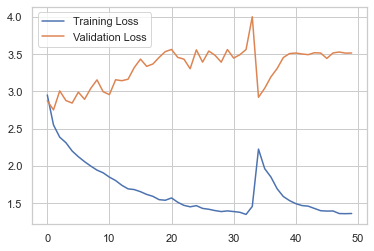

MAE =  2.7534410465728794
mean grade prediction =  5.0795074
mean grade =  6.840175150519978


,Text,Grade,Predicted Grade
1122,He handed her a golden flame,6.0,4.230372
2768,I wondered if anyone felt sorry for me,5.0,4.544572
5500,This showed scientists that she was trying to communicate her thoughts which takes big brainpower,6.0,4.848967
5679,As stated in Article VII One of its ( the Leagues ) jobs will be to come up with a plan for reducing the number of weapons around the world ( arms reduction ),8.0,6.176178
3651,I think she was 11 or 12 years old and I doubt she had ever been on a horse in her life,9.0,4.878436


In [11]:
history = model.fit(X_train, y_train,
                     batch_size=100,
                     epochs=50,
                     validation_split=.2,
                    callbacks=callbacks)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

model = keras.models.load_model('model1-best.hdf5')
yhat = model.predict(X_test).ravel()
print('MAE = ', np.sum(np.abs(y_test-yhat))/len(y_test))
print('mean grade prediction = ',np.mean(model.predict(X_train)))
print('mean grade = ', np.mean(y_train))

errors = df.loc[y_test.index][['Text','Grade']]
errors['Predicted Grade'] = yhat
errors.sample(5)

In [12]:
df

,Text,Grade
0,I had just gone to Chobot Space and Science Center,1.0
1,When I got there I didnt even know one planet in our solar system,1.0
2,Soon I learned all eight planets in our solar system,1.0
3,I learned what the first rocket ship looked like,1.0
4,I learned how to land a rocket ship,1.0
...,...,...
9378,Then you need to put the soil that you digd where the been is,2.0
9379,Lex go to step 4 : Then you put more soil if your been or seed wasent cover all with soil,2.0
9380,Lex go to step 5 : The last thing to do with your been or seed put water in the soil that you had in your cup thet sead your name,2.0
9381,Then you wait some days for your plant could grow,2.0


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3937500   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 50)          70200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                3264      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

Epoch 27/50
59/59 [==============================] - ETA: 0s - loss: 1.7543
Epoch 00027: val_loss did not improve from 2.10213
59/59 [==============================] - 9s 147ms/step - loss: 1.7543 - val_loss: 2.1648
Epoch 28/50
59/59 [==============================] - ETA: 0s - loss: 1.7364
Epoch 00028: val_loss did not improve from 2.10213
59/59 [==============================] - 9s 145ms/step - loss: 1.7364 - val_loss: 2.1428
Epoch 29/50
59/59 [==============================] - ETA: 0s - loss: 1.7050
Epoch 00029: val_loss did not improve from 2.10213
59/59 [==============================] - 8s 142ms/step - loss: 1.7050 - val_loss: 2.1208
Epoch 30/50
59/59 [==============================] - ETA: 0s - loss: 1.7100
Epoch 00030: val_loss did not improve from 2.10213
59/59 [==============================] - 9s 146ms/step - loss: 1.7100 - val_loss: 2.1773
Epoch 31/50
59/59 [==============================] - ETA: 0s - loss: 1.6883
Epoch 00031: val_loss did not improve from 2.10213
59/59 [==

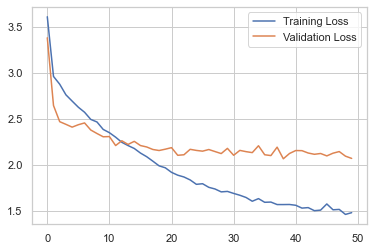

OSError: SavedModel file does not exist at: /content/model2-best.hdf5/{saved_model.pbtxt|saved_model.pb}

In [13]:
def make_model2():

    model = Sequential()

    model.add(embedding_layer)
    model.add(LSTM(50, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))  
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))  
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4))) 
    model.add(Dropout(0.3))
 
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=.01, decay=1e-3)
    model.compile(optimizer = adam, loss = 'mean_absolute_error', metrics = None)
    
    return model
model = make_model2()
print(model.summary())
filepath = 'model2-best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

history = model.fit(X_train, y_train,
                     batch_size=100,
                     epochs=50,
                     validation_split=.2,
                    callbacks=callbacks)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

model = keras.models.load_model('/content/model2-best.hdf5')
yhat = model.predict(X_test).ravel()
print('MAE = ', np.sum(np.abs(y_test-yhat))/len(y_test))
print('mean grade prediction = ',np.mean(model.predict(X_train)))
print('mean grade = ', np.mean(y_train))

errors = df.loc[y_test.index][['Text','Grade']]
errors['Predicted Grade'] = yhat
errors.sample(5)

In [ ]:
def make_model3():

    model = Sequential()

    model.add(embedding_layer)
    model.add(LSTM(100, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))  
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))  
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4))) 
    model.add(Dropout(0.3))
 
    model.add(Dense(1))

    adam = optimizers.Adam(learning_rate=.01, decay=1e-3)
    model.compile(optimizer = adam, loss = 'mean_absolute_error', metrics = None)
    
    return model
model = make_model3()
print(model.summary())
filepath = 'model3-best.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

# history = model.fit(X_train, y_train,
#                      batch_size=100,
#                      epochs=200,
#                      validation_split=.2,
#                     callbacks=callbacks)

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.show()

model = keras.models.load_model('/content/model3-best.hdf5')
yhat = model.predict(X_test).ravel()
print('MAE = ', np.sum(np.abs(y_test-yhat))/len(y_test))
print('mean grade prediction = ',np.mean(model.predict(X_test)))
print('mean grade = ', np.mean(y_test))

errors = df.loc[y_test.index][['Text','Grade']]
errors['Predicted Grade'] = yhat
errors.sample(5)